<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Intro to MPI (collectives)

## Contents


In this notebook, we will continue learning the basics of parallel computing using the Message Passing Interface (MPI) from Julia. In particular, we will learn:

- How to use basic collective communication directives
- How to use MPI communicators


## Collective communication

MPI provides a set of routines for communication involving multiple processes. These are called *collective communication* operations. Some usual collective operations are:


- `MPI_Barrier`: Synchronize all processes
- `MPI_Bcase`: Send the same data from one to all processes
- `MPI_Gather`: Gather data from all processes to one
- `MPI_Scatter`: Scatter data from one to all all processes
- `MPI_Reduce`: Reduce data from all processes to a single one
- `MPI_Scan`: Scan (or prefix) reduction
- `MPI_Allgather`: Like a `MPI_Gather` but all processes receive the result
- `MPI_Allreduce`: Like `MPI_Reduce` but all processes receive the result
- `MPI_Alltoall`:  Exchange data from all to all processes


We will discuss some of them in greater detail in this notebook.

## Why collective operations?

Point-to-point communication functions provide all the building blocks needed in parallel programs and could be used to implement the collective functions described above. Then, why does MPI provide collective communication functions? There are several reasons:

- Ease of use: It is handy for users to have these functions readily available instead of having to implement them.
- Performance: Library implementations typically use efficient algorithms (such as reduction trees).
- Hardware support: Hardware vendors can optimize the MPI library for their machine and even develop hardware specially design to perform MPI operations efficiently. For instance, [IMB Blue Gene](https://en.wikipedia.org/wiki/IBM_Blue_Gene) was equipped with  auxiliary networks for MPI collectives.


## Semantics of collective operations

These are key properties of collective operations:


- Completeness: All the collective communication directives above are *complete* operations. Thus, it is safe to use and reset the buffers once the function returns.
- Standard mode: Collective directives are in standard mode only, like `MPI_Send`. Assuming that they block is erroneous, assuming that they do not block is also erroneous.
- Synchronization:  Completion of a call does not guarantee that other processes have completed the operation. A collective operation may or may not have the effect of synchronizing all processes, the only exception is `MPI_Barrier` of course.


<div class="alert alert-block alert-info">
<b>Note:</b> Recent versions of the MPI standard also include non-blocking (i.e., incomplete) versions of collective operations (not covered in this notebook). A particularly funny one is the non-blocking barrier `MPI_Ibarrier`.
</div>

## MPI_Barrier

This function is used to synchronizes a group of processes. All processes block until all have reached the barrier. It is often invoked at the end of for loops to make sure all processes have finished the current loop iteration to move to the next one. We will see a practical example later in another notebook when studying the traveling sales person problem (TSP).

In Julia:
```julia
MPI.Barrier(comm)
```

In C:
```c
int MPI_Barrier(MPI_Comm comm)
```

### Example

In this example the ranks sleep for a random amount of time and then they call barrier. It is guaranteed that the message "Done!" will be printed after all processes printed "I woke up" since we used a barrier. Try also to comment out the call to `MPI.Barrier`. You will see that the message can be printed in any order.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    sleep(rand(1:3))
    println("[rank $rank] I woke up")
    MPI.Barrier(comm)
    println("[rank $rank] Done!")
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Reduce

This function combines values provided by different processors according to a given reduction operation. The result is received in a single process (called the root process).  The root process can be any process and it is rank 0 by default in Julia.

In Julia:
```julia
MPI.Reduce!(sendbuf, recvbuf, op, comm; root)
```

In C:
```
int MPI_Reduce(const void *sendbuf, void *recvbuf, int count,
               MPI_Datatype datatype, MPI_Op op, int root,
               MPI_Comm comm)
```



<div class="alert alert-block alert-info">
<b>Note:</b> `MPI_Reduce` (and related functions like `MPI_Allreduce`) use operations that are *commutative* and *associative*, such as addition, multiplication, maximum, minimum, logical and, logical or. Otherwise the result will be undefined as it will depend in which order the operations are done.
</div>


### Example
Each process generates a random integer. Compute the sum of all these integers. Receive the result on rank 0.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    value = rand(1:4)
    root = 0
    sndbuf = [value]
    if rank == root
        rcvbuf = [0]
    else
        # This can be anything as only the root process
        # Will receive data
        rcvbuf = nothing
    end
    println("[rank $rank] I am contributing with $sndbuf")
    MPI.Reduce!(sndbuf, rcvbuf, +, comm; root)
    println("[rank $rank] The sum is $rcvbuf")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Reducing multiple values

If more than one item is provided in the send buffers, `MPI_Reduce` does the reduction element by element.


### Example

Each process generates 2 random integers. Take a look to the result of reduce. Note that the values have ben reduced "element by element". 

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    sndbuf = rand(1:4,2)
    root = 0
    if rank == root
        rcvbuf = [0,0]
    else
        rcvbuf = nothing
    end
    println("[rank $rank] I am contributing with $sndbuf")
    MPI.Reduce!(sndbuf, rcvbuf, +, comm; root)
    println("[rank $rank] The sum is $rcvbuf")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## MPI_Allreduce

This is a variant of `MPI_Reduce` in which all processes get the result.

### Example

This is the same example as above, but all processes get the result.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    sndbuf = rand(1:4,2)
    # All ranks allocate a receive buffer
    rcvbuf = [0,0]
    println("[rank $rank] I am contributing with $sndbuf")
    MPI.Allreduce!(sndbuf, rcvbuf, +, comm)
    println("[rank $rank] The sum is $rcvbuf")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## MPI_Gather

Each rank sends a message to the root rank (the root rank also sends a message to itself). The root rank receives all these values in a buffer (e.g. a vector).

<div class="alert alert-block alert-info">
<b>Note:</b>  This function assumes that the amount of data sent from each rank is the same. See `MPI_Gatherv` below for more general cases.
</div>


In Julia:
```julia
MPI.Gather!(sendbuf, recvbuf, comm; root=0)
```

In C:
```c
int MPI_Gather(const void *sendbuf, int sendcount, MPI_Datatype sendtype,
    void *recvbuf, int recvcount, MPI_Datatype recvtype, int root,
    MPI_Comm comm)
```

### Example

Each process sends an integer to rank 0.


<div>
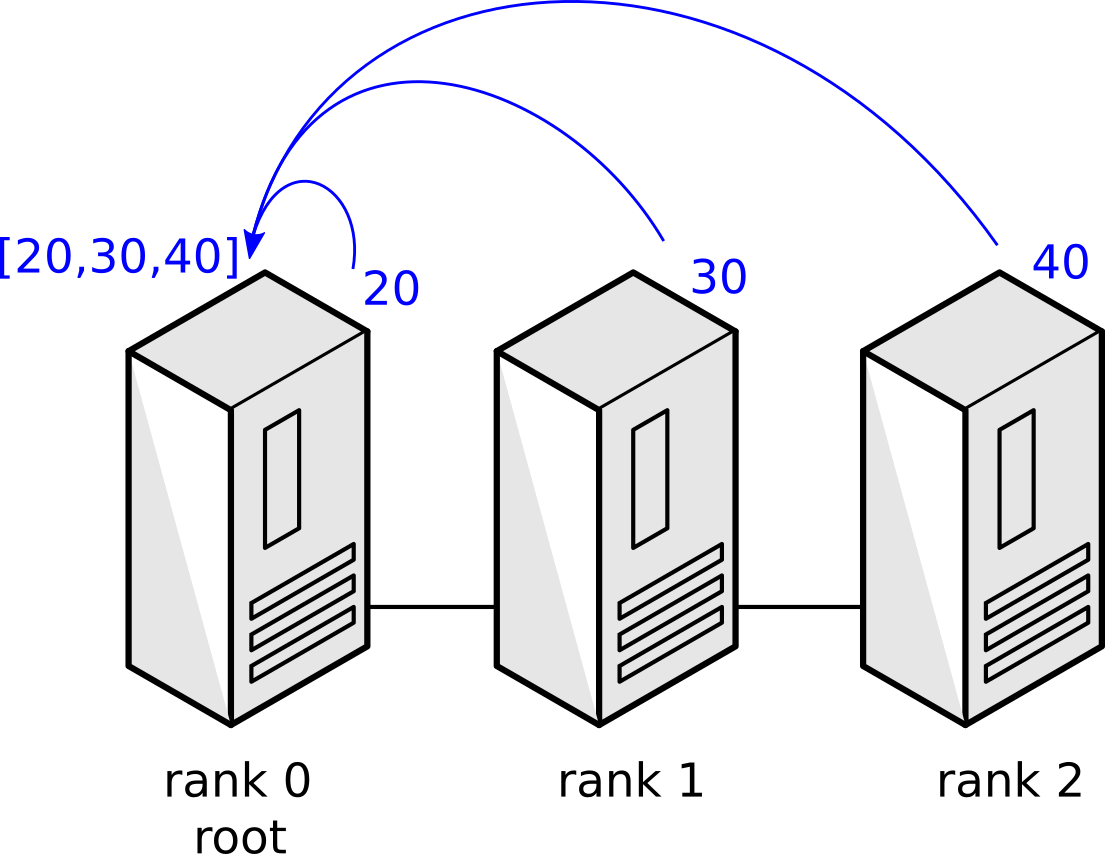
</div>
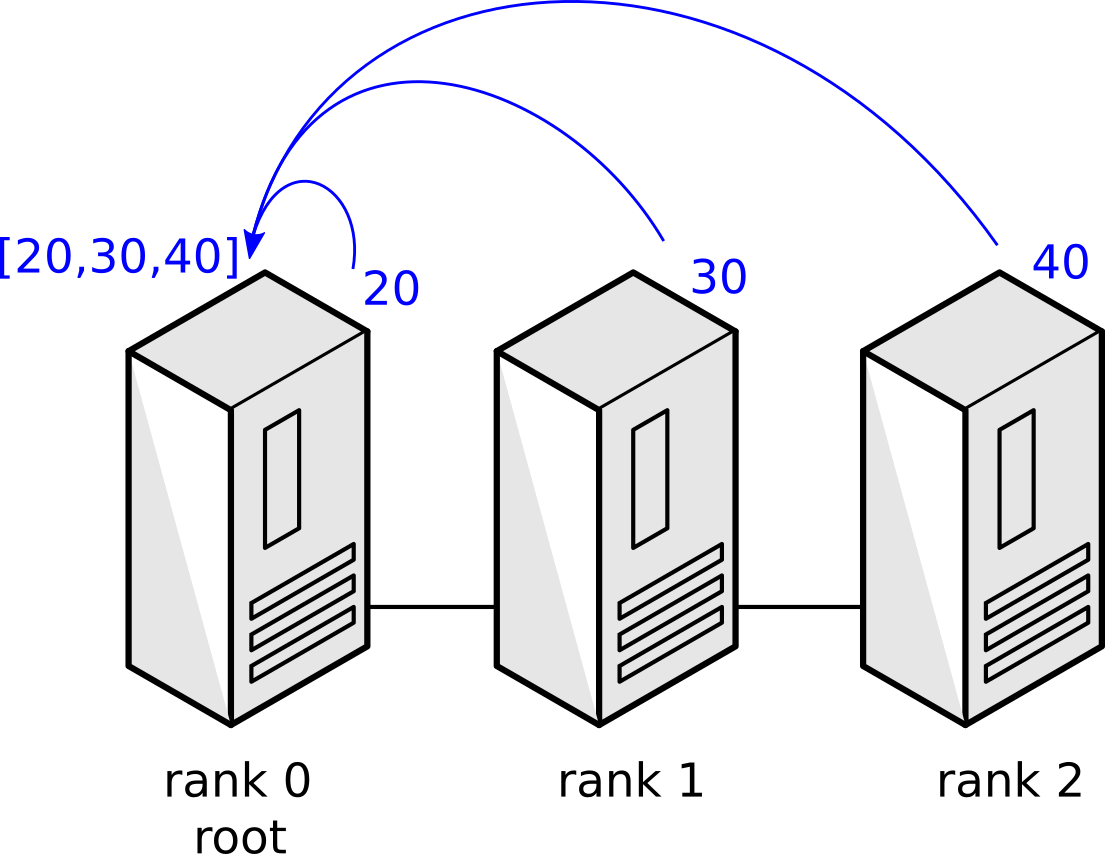

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    msg = 10*(rank+2)
    root = 0
    sndbuf = [msg]
    if rank == root
        nranks = MPI.Comm_size(comm)
        rcvbuf = zeros(Int,nranks)
    else
        # This can be anything as only the root process
        # Will receive data
        rcvbuf = nothing
    end
    println("[rank $rank] I am sending $sndbuf")
    MPI.Gather!(sndbuf, rcvbuf, comm; root)
    println("[rank $rank] I received $rcvbuf")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## MPI_Allgather

This is a variant of `MPI_Gather` in which all processes get the result.

### Example

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    msg = 10*(rank+2)
    sndbuf = [msg]
    nranks = MPI.Comm_size(comm)
    rcvbuf = zeros(Int,nranks)
    println("[rank $rank] I am sending $sndbuf")
    MPI.Allgather!(sndbuf, rcvbuf, comm)
    # All ranks receive the result
    println("[rank $rank] I received $rcvbuf")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## MPI_Gatherv

This function is similar to `MPI_Gather`, but it is used when there is a different amount of data sent from each process. There is also `MPI_Allgatherv` for which all processes will receive the result.

### Example

Each processes sends `rank+1` integers to rank 0.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    sndbuf = fill(10*rank,rank+1)
    root = 0
    if rank == root
        nranks = MPI.Comm_size(comm)
        # Define the amount of data to be received
        # from each rank
        counts = [ rank+1 for rank in 0:(nranks-1)]
        # Total amount of receive data
        ndata = sum(counts)
        data = zeros(Int,ndata)
        rcvbuf = MPI.VBuffer(data,counts)
    else
        # This can be anything as only the root process
        # Will receive data
        rcvbuf = nothing
    end
    println("[rank $rank] I am sending $sndbuf")
    MPI.Gatherv!(sndbuf, rcvbuf, comm; root)
    if rank == root
        println("[rank $rank] I received $data")
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## How to get the amount of data to be received?

Remember that `MPI_Probe` allows you to query the amount of data to be received with `MPI_Recv`. Unfortunately, this mechanism does not work for MPI collectives. A workaround is to first communicate the amount of data to be gathered, allocate the receive buffer accordingly, and then communicate the actual message.


### Example

Each process sends a random amount of integers to rank 0. The root process will not know the amount of data to be gathered from each rank in advance. We need an auxiliary gather to inform about the message size.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    # Get number of ints to send
    count = rand(1:4)
    # Generate data to send
    sndbuf = fill(rank,count)
    # Communicate counts
    root = 0
    if rank == root
        nranks = MPI.Comm_size(comm)
        counts = zeros(Int,nranks)
    else
        counts = nothing
    end
    MPI.Gather!([count], counts, comm; root)
    # Allocate receive buffer
    if rank == root
        ndata = sum(counts)
        data = zeros(Int,ndata)
        rcvbuf = MPI.VBuffer(data,counts)
    else
        rcvbuf = nothing
    end
    # Communicate data
    println("[rank $rank] I am sending $sndbuf")
    MPI.Gatherv!(sndbuf, rcvbuf, comm; root)
    if rank == root
        println("[rank $rank] I received $data")
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Scatter

This is the inverse operation of `MPI_Gather`. The root rank sends a distinct message to each rank.

In Julia:
```julia
MPI.Scatter!(sendbuf, recvbuf, comm; root=0)
```

In C:
```c
int MPI_Scatter(const void *sendbuf, int sendcount, MPI_Datatype sendtype,
    void *recvbuf, int recvcount, MPI_Datatype recvtype, int root,
    MPI_Comm comm)
```

<div class="alert alert-block alert-info">
<b>Note:</b> `MPI_Scatter` sends the same amount of data to each rank. To send a variable amount of data there is `MPI_Scatterv` (`MPI.Scatterv!` in julia), which works similar to `MPI_Gatherv`. 
</div>



### Example

Rank 0 sends a unique integer to each rank. 

<div>
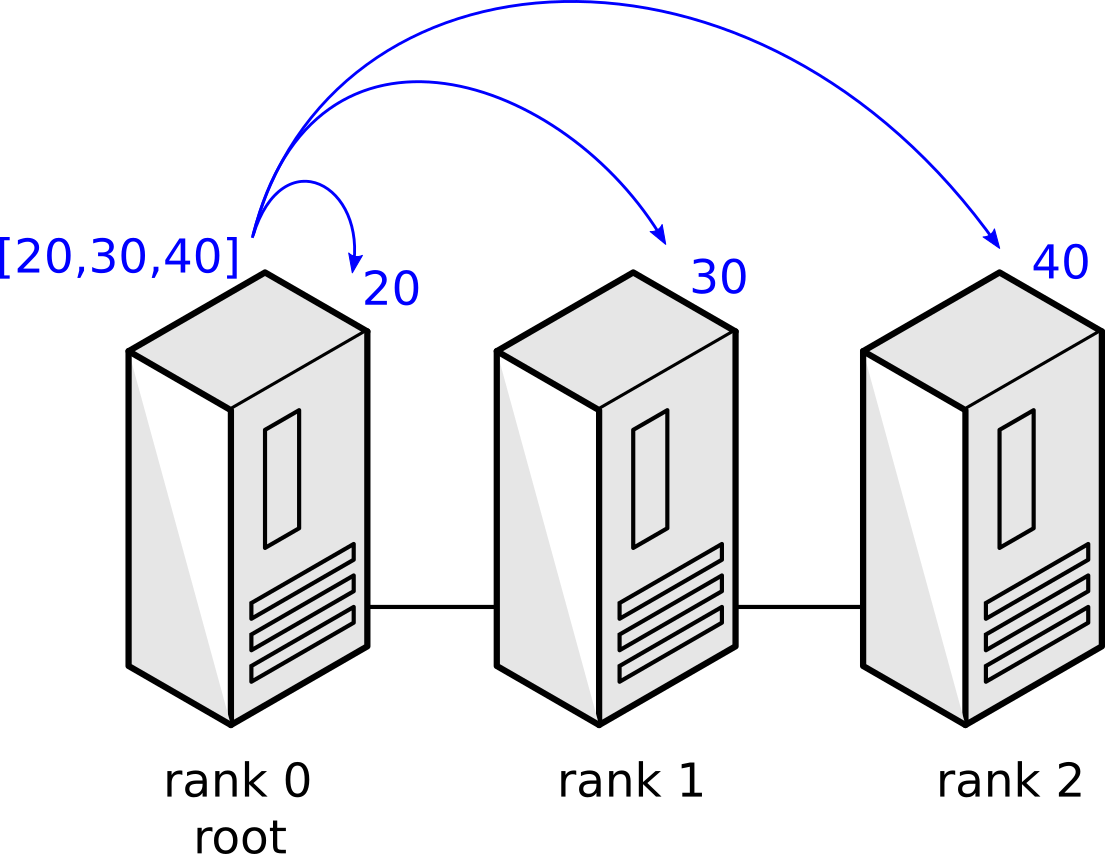
</div>
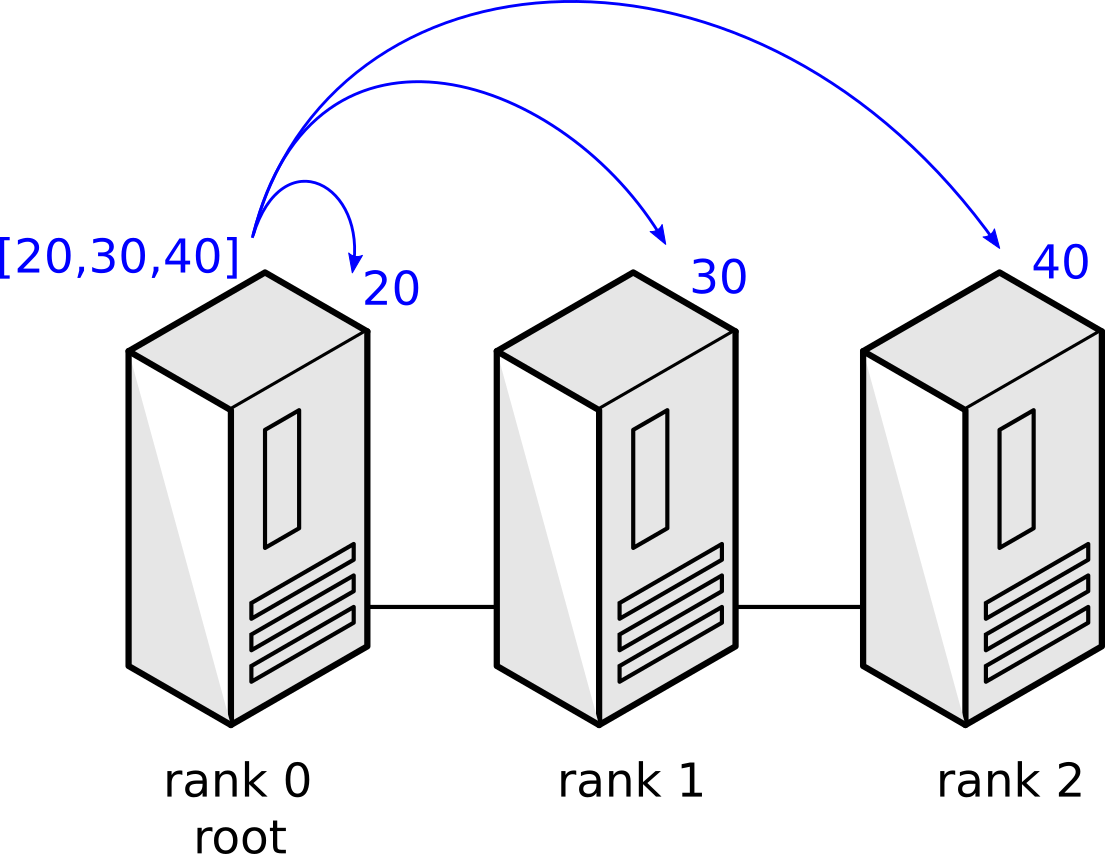

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    rcv = Ref(0) 
    if rank == root
        snd = [10*(i+1) for i in 1:nranks]
        println("[rank $rank] I am sending: $snd")
    else
        # Only the root rank sends data
        # so this can be anything
        snd = nothing
    end    
    MPI.Scatter!(snd,rcv,comm;root)
    println("[rank $rank] I have received: $(rcv[])")
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Bcast

Similar to `MPI_Scatter`, but we send the same message to all processes.

In Julia:
```julia
MPI.Bcast!(buf, comm; root)
```

In C:
```c
int MPI_Bcast(void *buffer, int count, MPI_Datatype datatype,
    int root, MPI_Comm comm)
```


### Example

Rank 0 sends the same integer to all processes.

<div>
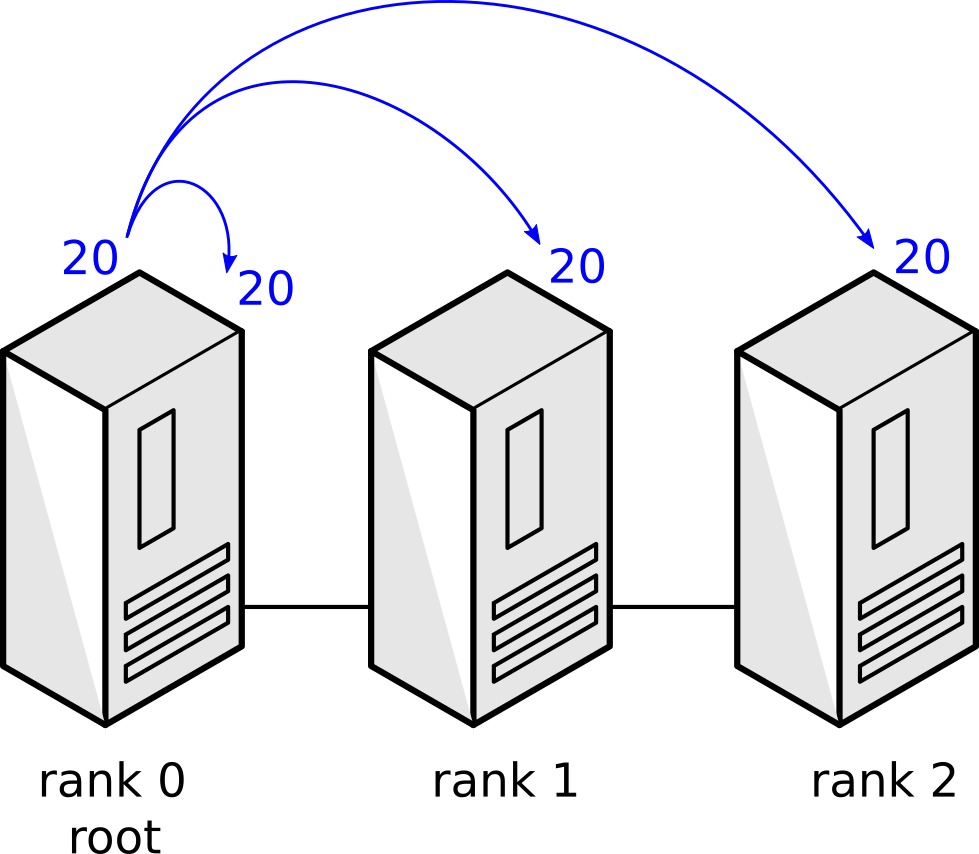
</div>
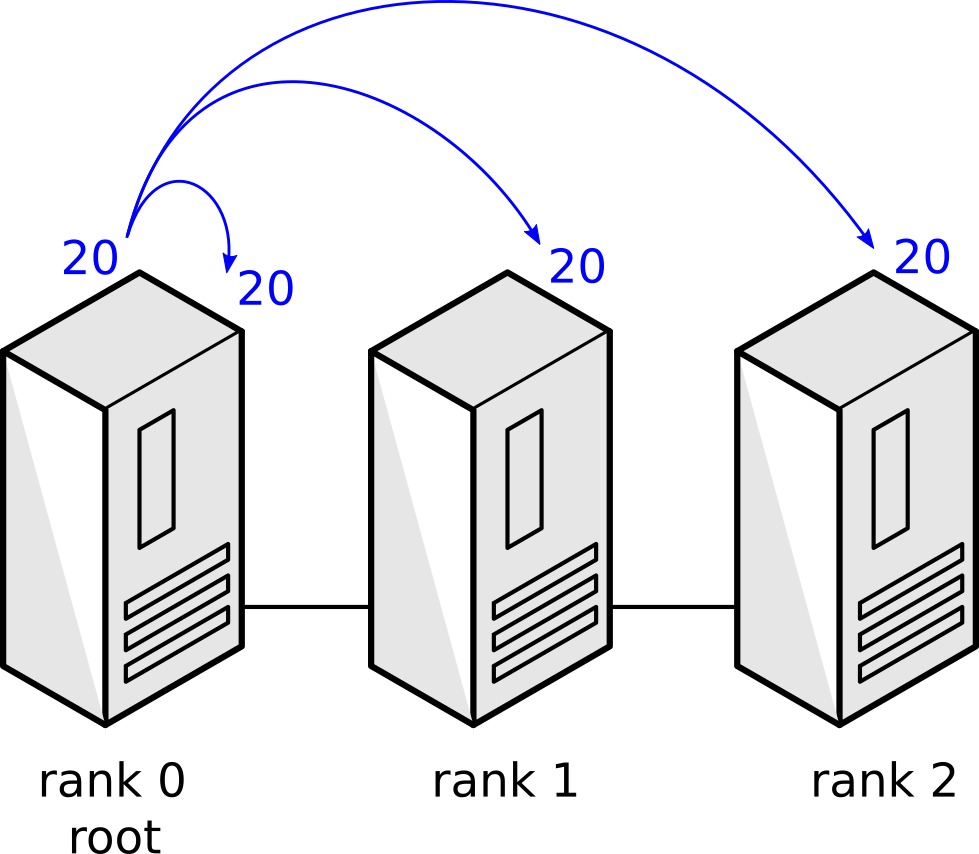

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    buffer = Ref(0)
    if rank == root
        buffer[] = 20
        println("[rank $rank] I am sending: $(buffer[])")
    end    
    MPI.Bcast!(buffer,comm;root)
    println("[rank $rank] I have received: $(buffer[])")
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Communicators

A key component in MPI programming are so-called communicators. A communicator object has to main purposes:


1. To provide an isolated communication context
2. To define a group of processes


### Communication context

When you write an MPI program it is very likely that you are going to use libraries that also use MPI to send messages. Ideally, these libraries should not interfere with application messages. Using tags to isolate the messages send by your application does not solve the problem. MPI communicators fix this problem as they provided an isolated communication context. For instance, `MPI_SEND` and `MPI_RECV` specify a communicator. `MPI_RECV` can only receive messages sent to same communicator. The same is also true for collective communication directives. If two libraries use different communicators, their message will never interfere. In particular it is recommended to never use the default communicator, `MPI_COMM_WORLD`, directly when working with other libraries. A new isolated communicator can be created with `MPI_Comm_dup`.


### Groups of processes

On the other hand,  imagine that we want to use an MPI communication directive like `MPI_Gather`, but we only want a subset of the processes to participate in the operation. So far, we have used always the default communication `MPI_COMM_WORLD`, which represents all processes. Thus, by using this communicator, we are including all processes in the operation. We can create other communicators that contain only a subset of processes. To this end, we can use function `MPI_Comm_split`.


## MPI_Comm_dup

Duplicate a given communicator, creating a new one with an new communication context.


In Julia:
```julia
newcomm = MPI.Comm_dup(comm)
```

In C:
```c
int MPI_Comm_dup(MPI_Comm comm, MPI_Comm *newcomm)
```

### Example

Send value 2 from rank 2 to rank 3. Then send value 1 also from rank 2 to rank 3. Note that we are using 2 different communicators for each send receive pair in such a way that we first receive value 1 and then value 2, even if this not was the other in which the data was sent. Try also to define `comm2 = comm` and see how the result will change.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    # We create a new communicator
    comm2 = MPI.Comm_dup(comm)
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [2]
        MPI.Send(sndbuf, comm2; dest=3, tag=0)
        sndbuf = [1]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,1)
        MPI.Recv!(rcvbuf, comm; source=2, tag=0)
        @show rcvbuf
        MPI.Recv!(rcvbuf, comm2; source=2, tag=0)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## MPI_Comm_split

Split a given communicator.


In Julia:

```julia
newcomm = MPI.Comm_split(comm, color, key)
```

In C:
```c
int MPI_Comm_split(MPI_Comm comm, int color, int key,
    MPI_Comm *newcomm)
```

There are two key parameters:

- `color`: all processes with the same color will be grouped in the same new communicator.
- `key`: The processes will be ranked in the new communicator according to key, breaking ties with the rank in the old communicator. 



### Example

Create two groups of processes, one for processes with rank id even, and another for the rest. Note that the rank id will be function of the given communicator.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    color = mod(rank,2)
    key = 0
    newcomm = MPI.Comm_split(comm, color, key)
    newrank = MPI.Comm_rank(newcomm)
    println("Hello, I am rank $rank in world and rank $newrank in group $color.")
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Example

Processes with odd rank id generate a random integer. Sum all these integers and send them to the first process with odd rank id. Note that we are using a new communicator to perform the reduction.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    color = mod(rank,2)
    key = 0
    newcomm = MPI.Comm_split(comm, color, key)
    # Only odd rank ids will execute this
    if color == 1
        newrank = MPI.Comm_rank(newcomm)
        newroot = 0
        sndbuf = [rand(1:4)]
        if newrank == newroot
            rcvbuf = [0]
        else
            rcvbuf = nothing
        end
        println("[rank $rank, newrank $newrank] I am contributing with $sndbuf")
        MPI.Reduce!(sndbuf, rcvbuf, +, newcomm;root=newroot)
        println("[rank $rank, newrank $newrank] The sum is $rcvbuf")
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

Try to run the code without splitting the communicator. I.e., replace `newcomm = MPI.Comm_split(comm, color, key)` with `newcomm = comm`. Try to figure out what will happen before executing the code.

## Conclusion

- MPI also defines operations involving several processes called, collective operations.
- These are provided both for convenience and performance.
- The semantics are equivalent to "standard mode" `MPI_Send`, but there are also non-blocking versions (not discussed in this notebook).
- Discovering message sizes is often done by communicating the message size, instead of using `MPI_Probe`.
- Finally, we discussed MPI communicators. They provide two key features: isolated communication context and creating groups of processes. They are useful, for instance, to combine different libraries using MPI in the same application, and to use collective operations in a subset of the processes.

After learning this material and the previous MPI notebook, you have a solid basis to start implementing sophisticated parallel algorithms using MPI.

## Exercises

### Exercise 1

Implement the parallel matrix-matrix multiplication (Algorithm 3) using MPI collectives instead of point-to-point communication. I.e., this is the same exercise as in previous notebook, but using different functions for communication.

# License

This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.